## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import make_interp_spline, BSpline

## Get Data

In [2]:
with open('./data/processed/codes_to_city_dict.txt', 'rb') as handle:
    codes_to_city = pickle.loads(handle.read())
dat = pd.read_pickle('./data/processed/final/all-sched-enriched.pkl')
dat.head()

,operator,flight,aircraft,craft_capacity,frequency,weekly_flights,weekly_capacity,weekly_est_pass,from,from_time,...,to_time_slot,eff_from,eff_to,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,IND,6E 101,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,MAA,6.25,...,15.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
1,IND,6E 103,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,PNQ,22.33,...,1.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
2,IND,6E 104,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,HYD,8.17,...,23.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
3,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,PNQ,17.33,...,38.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,False,True
4,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,DEL,14.75,...,34.0,2019-10-27 00:00:00,2020-03-27 00:00:00,True,True,True,True,True,False,True


### Overview

In [3]:
n_flights = dat['weekly_flights'].sum()
operators = dat['operator'].unique()
n_operators = len(operators)
cities = list(set(dat['from'].tolist() + dat['to'].tolist()))
n_cities = len(cities)

print('In a week, %i operators run %i domestic flights into and out of %i Indian cities.\n' % 
      (n_operators, n_flights, n_cities))
print('A flight departs from and arrives into a different city, so the %i flights result in' % n_flights)
print('a weekly total of %i arrivals and departures.' % (2*n_flights))

In a week, 9 operators run 21953 domestic flights into and out of 102 Indian cities.

A flight departs from and arrives into a different city, so the 21953 flights result in
a weekly total of 43906 arrivals and departures.


### By Cities

<ul>
    <li>Create a new dataframe by wrangling dat to identify for each city, across all carriers:
        <ol>
            <li>weekly total number of movements (arrivals plus departures).
            <li>weekly capacity.
            <li>weekly estimated passengers
        </ol>
</ul>

Identify the top cities that account for 80% of each weekly totals.

In [4]:
weeklies_ = ['weekly_flights', 'weekly_capacity', 'weekly_est_pass']

from_flights = dat.groupby(['from'])[weeklies_].sum()
to_flights = dat.groupby(['to'])[weeklies_].sum()

sdat = pd.concat([from_flights, to_flights], axis = 1, ignore_index = True)
sdat = sdat.fillna(0, axis = 1, downcast = 'infer') # if there are no flights either from or to a city, 
                                                    # replace NA by 0
sdat = sdat.rename(columns = {0:'from_weekly_flights', 
                                            3:'to_weekly_flights',
                                            1:'from_weekly_capacity',
                                            4:'to_weekly_capacity',
                                            2:'from_weekly_est_pass',
                                            5:'to_weekly_est_pass'}, errors = 'raise')

sdat['total_weekly_mvmnts'] = sdat.apply(lambda row: row.from_weekly_flights + row.to_weekly_flights,axis = 1)
sdat['total_weekly_capacity'] = sdat.apply(lambda row: row.from_weekly_capacity + row.to_weekly_capacity, 
                                           axis = 1)
sdat['total_weekly_est_pass'] = sdat.apply(lambda row: row.from_weekly_est_pass + row.to_weekly_est_pass, 
                                           axis = 1)

sdat.head()

,from_weekly_flights,from_weekly_capacity,from_weekly_est_pass,to_weekly_flights,to_weekly_capacity,to_weekly_est_pass,total_weekly_mvmnts,total_weekly_capacity,total_weekly_est_pass
AGR,4,280,218,4,280,218,8,560,436
AGX,7,490,383,7,490,383,14,980,766
AIP,7,546,500,7,546,500,14,1092,1000
AJL,11,1342,1046,24,3782,3223,35,5124,4269
AMD,764,124123,109080,750,120574,105987,1514,244697,215067


In [5]:
def top_cities_feature(df, feature, threshold):
    '''
    
    Returns the list top cities (by code) that account for threshold percentage of weekly total of the 
    desired feature.
    
    '''
    
    df = df.sort_values(by = [feature], ascending = False)
    total = df[feature].sum()
    top_cities = round(df[feature].cumsum()/total, 2)
        
    return top_cities[top_cities <= threshold].index.tolist()

#### Top Cities by Weekly Movements

20 cities account for 80% of weekly movements.

Cities accounting for 80% of weekly movements:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Jaipur', 'Lucknow', 'Patna', 'Kochi', 'Bhubaneswar', 'Varanasi', 'Indore', 'Coimbatore', 'Bagdogra', 'Chandigarh'] 



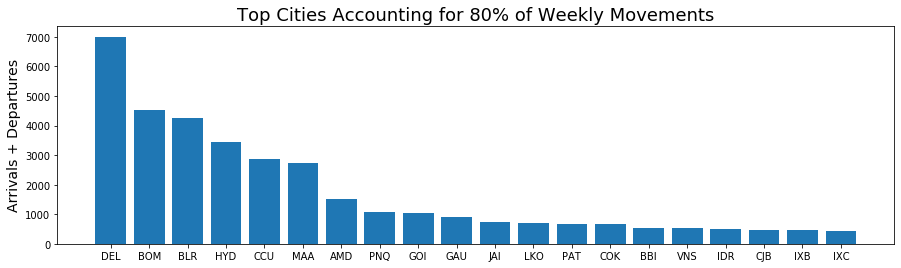

In [6]:
top_cities = top_cities_feature(sdat, 'total_weekly_mvmnts', 0.8)
top_cities_name = [codes_to_city[city] for city in top_cities]

print('%i cities account for 80%% of weekly movements.\n' % len(top_cities))
print('Cities accounting for 80% of weekly movements:\n', top_cities_name, '\n')

plt.figure(figsize = (15,4))
y = [sdat.iloc[sdat.index == city]['total_weekly_mvmnts'][0] for city in top_cities]
plt.bar(top_cities, y)
plt.title('Top Cities Accounting for 80% of Weekly Movements', size = 18)
plt.ylabel('Arrivals + Departures', size = 14)
plt.show()

#### Top Cities by Weekly Capacity

17 cities account for 80% of weekly capacity.

Cities accounting for 80% of weekly capacity:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Lucknow', 'Patna', 'Jaipur', 'Kochi', 'Bhubaneswar', 'Indore', 'Varanasi'] 



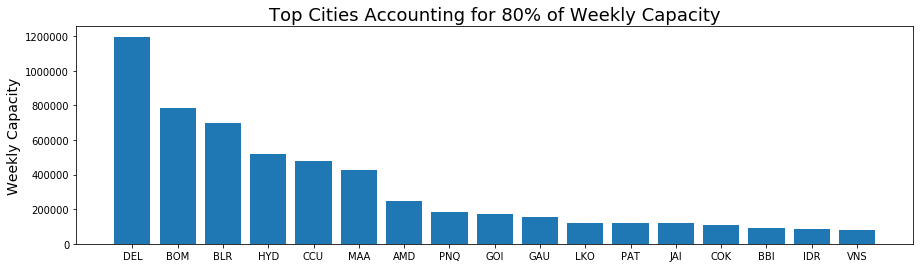

In [7]:
top_cities = top_cities_feature(sdat, 'total_weekly_capacity', 0.8)
top_cities_name = [codes_to_city[city] for city in top_cities]

print('%i cities account for 80%% of weekly capacity.\n' % len(top_cities))
print('Cities accounting for 80% of weekly capacity:\n', top_cities_name, '\n')

plt.figure(figsize = (15,4))
y = [sdat.iloc[sdat.index == city]['total_weekly_capacity'][0] for city in top_cities]
plt.bar(top_cities, y)
plt.title('Top Cities Accounting for 80% of Weekly Capacity', size = 18)
plt.ylabel('Weekly Capacity', size = 14)
plt.show()

#### Top Cities by Weekly Estimated Passengers

17 cities account for 80% of weekly estimated passengers.

Cities accounting for 80% of weekly estimated passengers:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Lucknow', 'Patna', 'Jaipur', 'Kochi', 'Bhubaneswar', 'Varanasi', 'Indore'] 



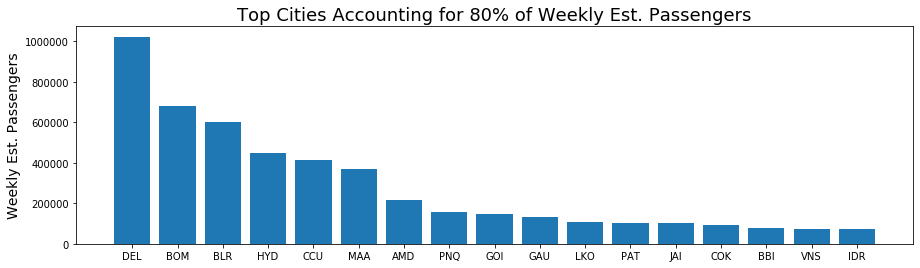

In [8]:
top_cities = top_cities_feature(sdat, 'total_weekly_est_pass', 0.8)
top_cities_name = [codes_to_city[city] for city in top_cities]

print('%i cities account for 80%% of weekly estimated passengers.\n' % len(top_cities))
print('Cities accounting for 80% of weekly estimated passengers:\n', top_cities_name, '\n')

plt.figure(figsize = (15,4))
y = [sdat.iloc[sdat.index == city]['total_weekly_est_pass'][0] for city in top_cities]
plt.bar(top_cities, y)
plt.title('Top Cities Accounting for 80% of Weekly Est. Passengers', size = 18)
plt.ylabel('Weekly Est. Passengers', size = 14)
plt.show()

#### Day-of-Week Distribution

<ul>
    <li>Plot the day-wise distribution for all arrivals and departures combined across all cities.
    <li>For the top cities by total weekly movements, for each city:
        <ol>
            <li>identify all schedules in and out of the city.
            <li>group the schedules by day of the week and count the total number of flights for the day.
            <li>plot the spread of the total daily movements for the city

In [9]:
def city_day_mvmnts(df, city = 'ALL'):
    
    ''' 
    
    For a city, returns the count of inward, outward and total movements by day of week.
    
    When combined across all cities, for any day, the total number of arrivals must be equal to the total
    number of departures. However, this may not be true when considering a particular city, i.e. the total 
    number of arrivals in a city may not be the same as the total number of departures. 
    
    '''
    
    day_mvmnts_in = []
    day_mvmnts_out = []
    day_mvmnts = []
    
    if city == 'ALL':
        for i in range(1,8,1):
            day = 'day_' + str(i)
            day_mvmnts_out.append(df.groupby([day, 'from'])[day].count()[1].sum())
    
        day_mvmnts = [value*2 for value in day_mvmnts_out]
    
    else:    
        idx = [i for i in df.index if df['from'][i] == city or df['to'][i] == city]
        df_city = df.iloc[idx, :]

        idx_in = [i for i in df_city.index if df_city['from'][i] != city] # flights into the city
        idx_out = [i for i in df_city.index if df_city['to'][i] != city]  # flights out of the city

        for i in range(1,8,1):
            day = 'day_' + str(i)
            try:
                foo = df_city.loc[idx_in, :].groupby([day, 'from'])[day].count()[1].sum()
            except KeyError:
                foo = 0
            day_mvmnts_in.append(foo)
            try:
                foo = df_city.loc[idx_out, :].groupby([day, 'to'])[day].count()[1].sum()
            except KeyError:
                foo = 0
            day_mvmnts_out.append(foo)

        day_mvmnts = [sum(x) for x in zip(day_mvmnts_in, day_mvmnts_out)]
    
    return day_mvmnts
    

In [107]:
def day_of_week_plot(mvmnts, city = 'ALL', spline_pts = 100, smoothing_param = 2):
    
    '''
    
    Plots a smooth curve (spline) of Day-of-Week distribution of movements.
    
    mvmnts - List of aggregate (days of week or timeslot of day) movements
    city - either 'ALL' for all cities combined or the relevant IATA code for a specific city
    spline_pts, smoothing_param - parameters of the spline drawn
    
    '''
        
    x_orig = np.arange(1, 8 ,1)
    x_augm = np.linspace(1, 7, spline_pts)

    spline = make_interp_spline(x_orig, mvmnts, k = smoothing_param)
    y_axis = np.maximum(np.zeros(spline_pts), spline(x_augm))   # prevent y from taking a negative value
    y_axis = (y_axis/np.max(y_axis))*100                        # daily flights scaled [0, max_val_for_week]

    plt.plot(x_augm, y_axis)

    plt.xlabel('Day of the Week')
    plt.ylabel('% of Max Daily Flights in a Week')

    if city == 'ALL': 
        plt.title('Daily Total Movements - All Cities')
        plt.ylim((90, 105))
    else:
        plt.title('Daily Total Movements in %s' % codes_to_city[city])
        plt.ylim((80, 105))

    return

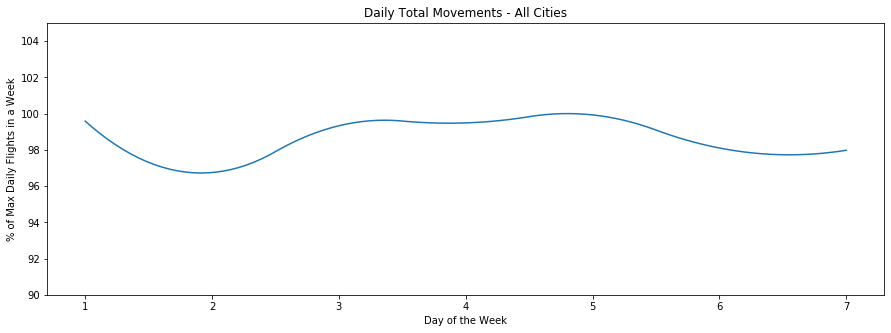

In [105]:
# For all cities combined

day_mvmnts = city_day_mvmnts(dat)

plt.figure(figsize = (15, 5))

day_of_week_plot(day_mvmnts)

plt.show()

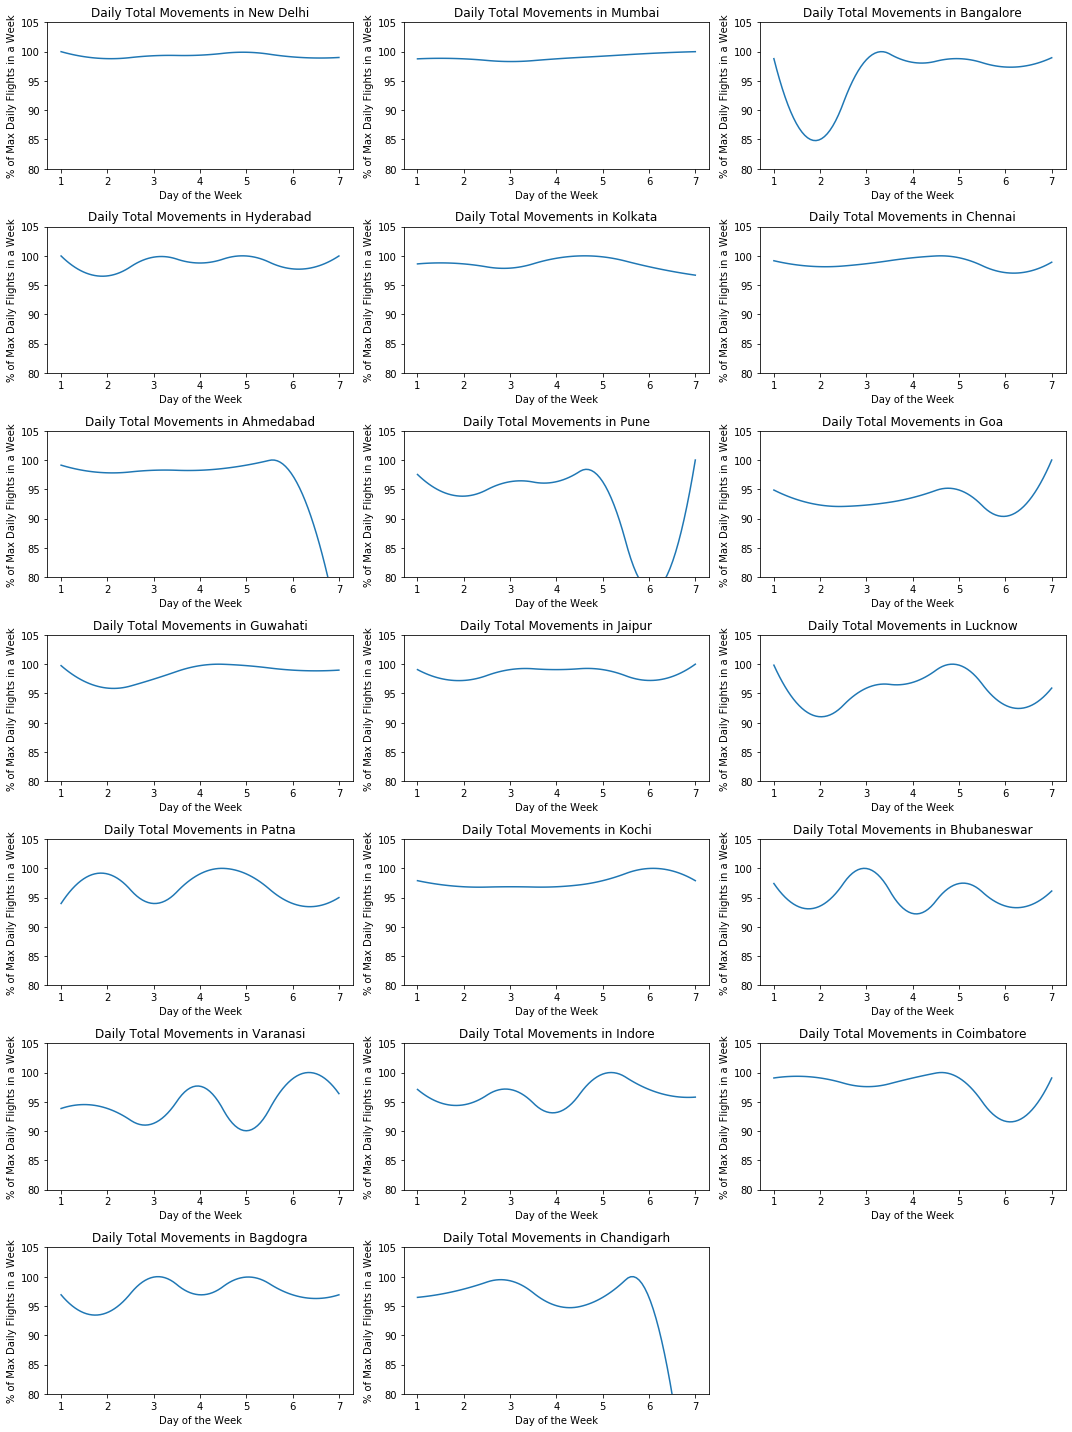

In [109]:
# For top cities by movements.

top_cities = top_cities_feature(sdat, 'total_weekly_mvmnts', 0.8)

plt.figure(figsize = (15, 20))

# Setting up some defaults for subplots
ncol = 3
nrow = np.ceil(len(top_cities)/ncol)
subplt_id = 1

for city in top_cities:
    day_mvmnts = city_day_mvmnts(dat, city)
      
    plt.subplot(nrow, ncol, subplt_id)
    subplt_id += 1
    
    day_of_week_plot(day_mvmnts, city = city)

plt.tight_layout()
plt.show()

### Time-of-Day Distribution

In [58]:
def city_time_mvmnts(df, city = 'ALL'):
    
    ''' 
    
    For a city, returns the average daily count of total movements by time of day.
    
    '''
    
    time_mvmnts_in = []
    time_mvmnts_out = []
    
    if city == 'ALL':
        for i in range(1, 49, 1):
            try:
                foo = df.groupby(['to_time_slot'])['weekly_flights'].sum()[i]
            except KeyError:
                foo = 0
            time_mvmnts_in.append(foo)
            try:
                foo = df.groupby(['from_time_slot'])['weekly_flights'].sum()[i]
            except KeyError:
                foo = 0
            time_mvmnts_out.append(foo)
    else:
        for i in range(1, 49, 1):
            try:
                foo = df.query('to == @city').groupby(['to_time_slot'])['weekly_flights'].sum()[i]
            except KeyError:
                foo = 0
            time_mvmnts_in.append(foo)
            try:
                foo = df.query('`from` == @city').groupby(['from_time_slot'])['weekly_flights'].sum()[i]
            except KeyError:
                foo = 0
            time_mvmnts_out.append(foo)
    
    time_mvmnts = [sum(x) for x in zip(time_mvmnts_in, time_mvmnts_out)]
    time_mvmnts = [x/7 for x in time_mvmnts]     # Averaging for the 7 days of the week
    
    return time_mvmnts
    

In [110]:
def time_of_day_plot(mvmnts, city = 'ALL', spline_pts = 100, smoothing_param = 2):
    
    '''
    
    Plots a smooth curve (spline) of Time-of-Day distribution of movements.
    
    mvmnts - List of aggregate (days of week or timeslot of day) movements
    city - either 'ALL' for all cities combined or the relevant IATA code for a specific city
    spline_pts, smoothing_param - parameters of the spline drawn
    
    '''
        
    x_orig = np.arange(1, 49 ,1)
    x_augm = np.linspace(1, 48, spline_pts)

    spline = make_interp_spline(x_orig, mvmnts, k = smoothing_param)
    y_axis = np.maximum(np.zeros(spline_pts), spline(x_augm))   # prevent y from taking a negative value

    plt.plot(x_augm, y_axis)

    plt.xlabel('Hour of the Day')
    plt.xticks(np.arange(0, 49, 2), labels = np.arange(0, 25, 1)) # to get 24 hours on the x-axis
    plt.axvline(x = 12, color = 'black', linestyle = '--')         # 6 a.m.
    plt.axvline(x = 24, color = 'black', linestyle = '--')         # 12 noon
    plt.axvline(x = 36, color = 'black', linestyle = '--')         # 6 p.m.
    if city == 'ALL': 
        plt.title('Average Hourly Movements In a Day - All Cities')
    else: 
        plt.title('Average Hourly Movements In a Day in %s' % codes_to_city[city])

    return

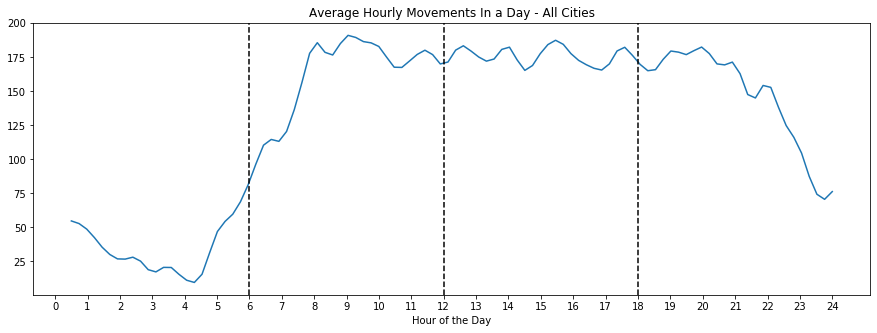

In [111]:
# For all cities combined

time_mvmnts = city_time_mvmnts(dat)

plt.figure(figsize = (15, 5))
time_of_day_plot(time_mvmnts)

plt.show()

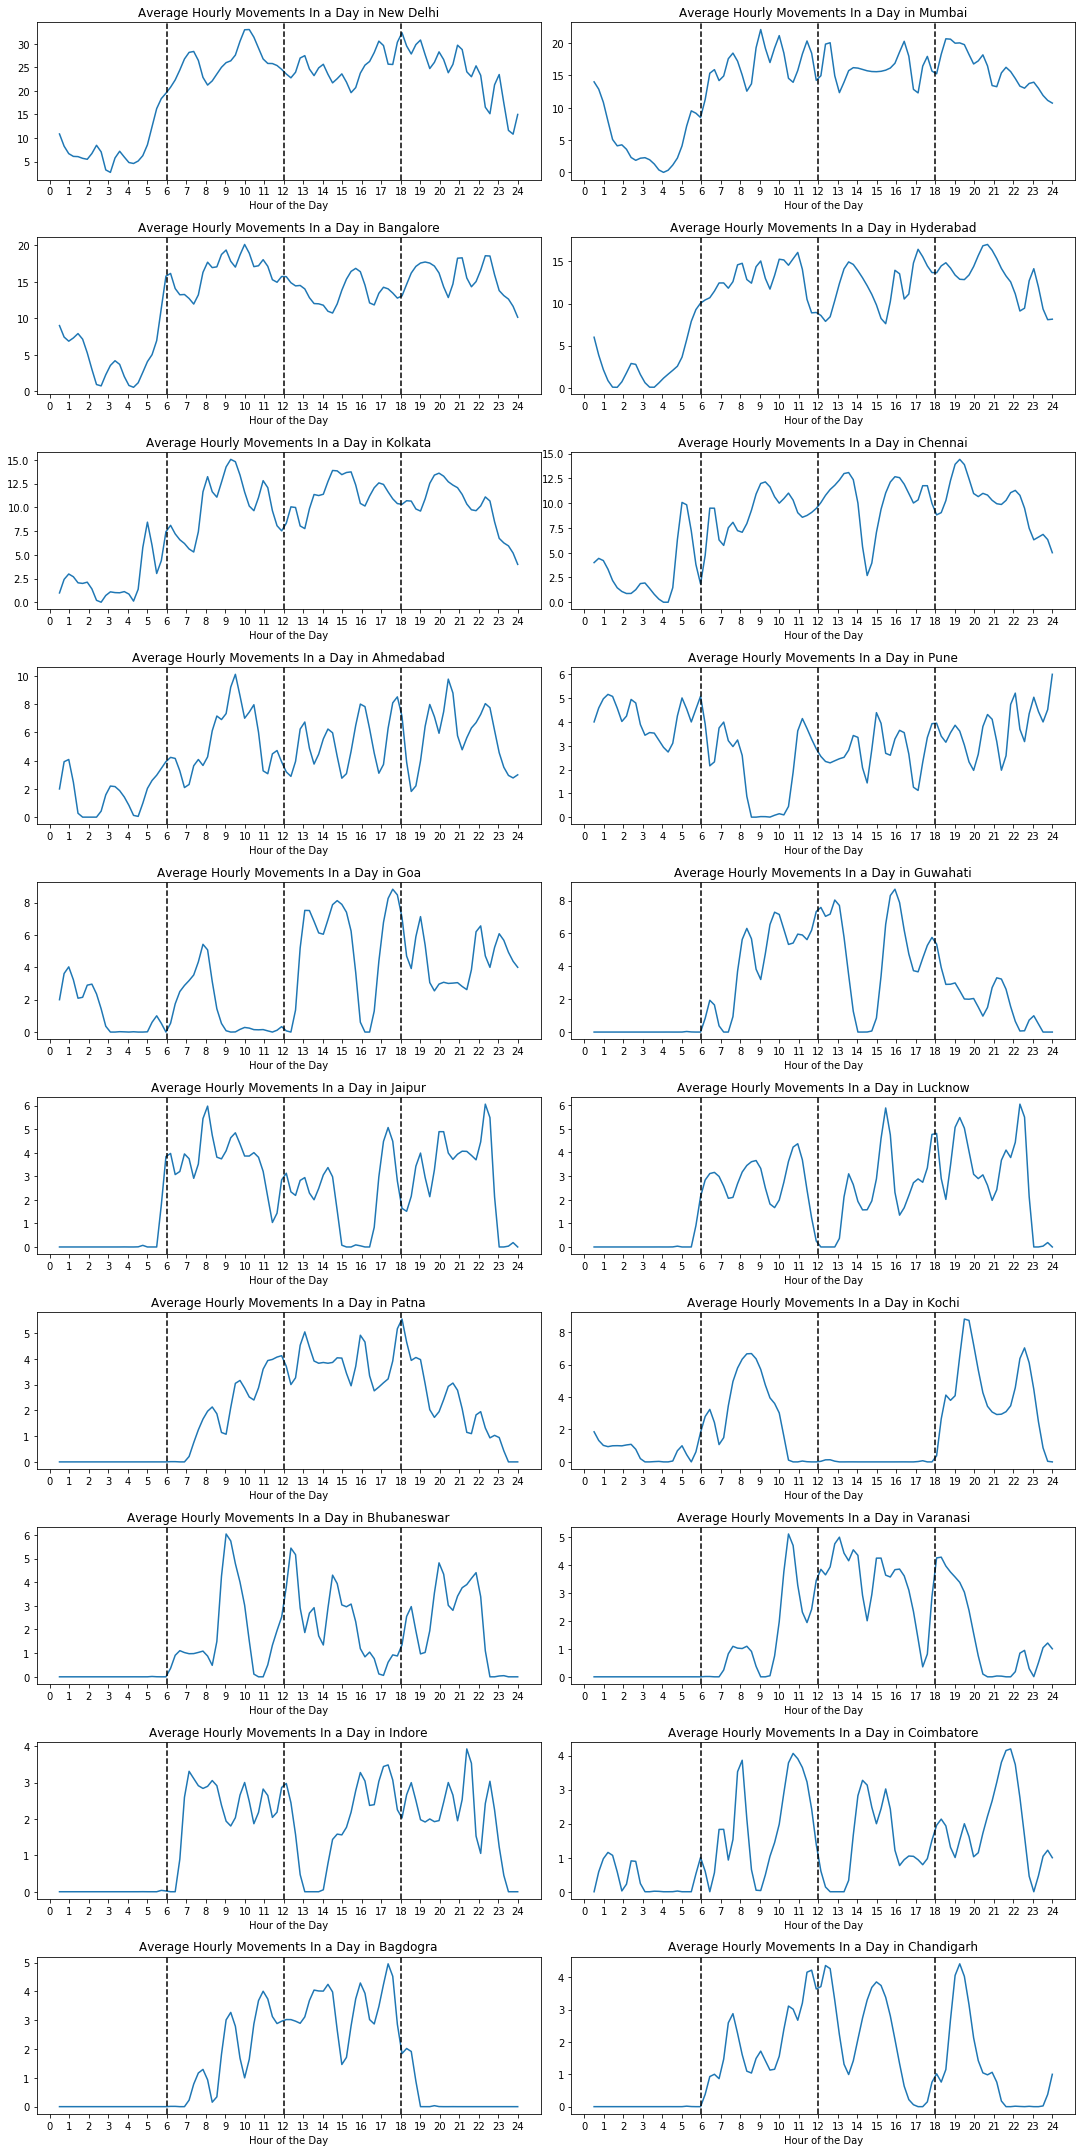

In [113]:
# For top cities by movements.

top_cities = top_cities_feature(sdat, 'total_weekly_mvmnts', 0.8)

plt.figure(figsize = (15, 30))

# Setting up some defaults for plots
ncol = 2
nrow = np.ceil(len(top_cities)/ncol)
subplt_id = 1

for city in top_cities:
    time_mvmnts = city_time_mvmnts(dat, city = city)
    
    plt.subplot(nrow, ncol, subplt_id)
    subplt_id += 1
    time_of_day_plot(time_mvmnts, city = city)

plt.tight_layout()
plt.show()